In [28]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

data = pd.read_csv('combined_league_matches.csv')

def jaccard_similarity(set1, set2):
    intersection = len(set1 & set2)
    union = len(set1 | set2)
    return intersection / union if union != 0 else 0

# Precompute the sets for historical winning teams
winning_teams = []

for i, row in data.iterrows():
    if row['winner'] == 'blue':
        winning_teams.append(frozenset([
            row['blue_champion_0'], row['blue_champion_1'], 
            row['blue_champion_2'], row['blue_champion_3'], row['blue_champion_4']
        ]))
    else:
        winning_teams.append(frozenset([
            row['red_champion_0'], row['red_champion_1'], 
            row['red_champion_2'], row['red_champion_3'], row['red_champion_4']
        ]))

# Optimize by limiting to the last N historical games
N = 1000
recent_winning_teams = winning_teams[-N:]

blue_team_similarities = []
red_team_similarities = []

for i, row in data.iterrows():
    blue_team = frozenset([
        row['blue_champion_0'], row['blue_champion_1'], 
        row['blue_champion_2'], row['blue_champion_3'], row['blue_champion_4']
    ])
    red_team = frozenset([
        row['red_champion_0'], row['red_champion_1'], 
        row['red_champion_2'], row['red_champion_3'], row['red_champion_4']
    ])

    blue_sim = max([jaccard_similarity(blue_team, win) for win in recent_winning_teams])
    red_sim = max([jaccard_similarity(red_team, win) for win in recent_winning_teams])
    blue_team_similarities.append(blue_sim)
    red_team_similarities.append(red_sim)

data['blue_team_similarity'] = blue_team_similarities
data['red_team_similarity'] = red_team_similarities

X = data[['blue_team_similarity', 'red_team_similarity']]
y = data['winner'].map({'blue': 1, 'red': 0})

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.2f}")


Model Accuracy: 0.54


/Users/warrenli/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/warrenli/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/l

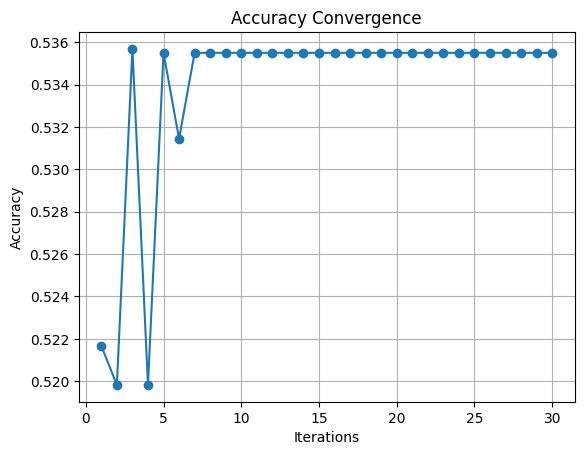

In [11]:
import matplotlib.pyplot as plt

# Enable warm_start for iterative convergence tracking
clf = LogisticRegression(max_iter=1, warm_start=True, solver='lbfgs')

accuracies = []

for i in range(1, 31):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)

plt.plot(range(1, 31), accuracies, marker='o')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.title('Accuracy Convergence')
plt.grid()
plt.show()